In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#miscellaneous imports for the project
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt # for plotting

import numpy as np

import os
from glob import glob
import time

from PIL import Image
import json

In [8]:
#load a subset of the data
#using the HanCo tester: 1 person, 8 camera angles, 67 images at each angle, 5 different sets (backgrounds) ~= 2680 images
#train loader - image then tuple of coordinates in 2d space (i.e. where they would be overlayed on an image)

base_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/mini_project_dataset/HanCo_tester"
folders = ["rgb", "rgb_color_auto", "rgb_color_sample", "rgb_homo", "rgb_merged"]

all_images = []

for folder in folders:
  pattern = os.path.join(base_dir, folder, "*", "cam*", "*.jpg")
  all_images.extend(glob(pattern))

print(f"found {len(all_images)} images")

train_val, test = train_test_split(all_images, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)  # 20% of train_val -> val

print(len(train), len(val), len(test))


found 2680 images
1929 483 268


In [41]:
class HandDataset(Dataset):
    def __init__(self, image_paths, xyz_root, transform=None):
        self.image_paths = image_paths
        self.xyz_root = xyz_root  # now required
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        camera_idx = int(os.path.basename(os.path.dirname(img_path))[3:])
        frame_num = int(os.path.basename(img_path).split(".")[0])

        # Load corresponding xyz keypoints
        frame_num = os.path.basename(img_path).split(".")[0]  # e.g., '00000006'
        xyz_path = os.path.join(self.xyz_root, frame_num + ".json")
        if not os.path.exists(xyz_path):
            raise FileNotFoundError(f"Missing xyz file for frame {frame_num}")
        with open(xyz_path, "r") as f:
            xyz = json.load(f)
        xyz = torch.tensor(xyz, dtype=torch.float32)

        return {"image": img, "xyz": xyz, "camera_idx": camera_idx, "frame_num": frame_num}

In [42]:
#making the data loaders for training, validation, testing

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HandDataset(train, xyz_root=os.path.join(base_dir, "xyz/0110"), transform=transform)
val_dataset = HandDataset(val, xyz_root=os.path.join(base_dir, "xyz/0110"), transform=transform)
test_dataset = HandDataset(test, xyz_root=os.path.join(base_dir, "xyz/0110"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


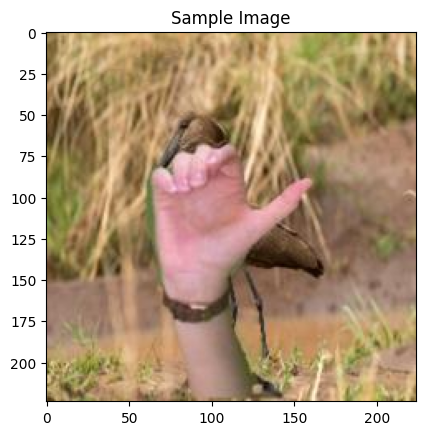

XYZ coordinates:
 [[-0.15608107 -0.06384409  0.5742791 ]
 [-0.17377445 -0.0743777   0.60758936]
 [-0.190247   -0.08997495  0.6303618 ]
 [-0.19968455 -0.10134128  0.65256417]
 [-0.21479523 -0.11631291  0.6776557 ]
 [-0.1531147  -0.11596148  0.6413756 ]
 [-0.1459531  -0.11279296  0.6645118 ]
 [-0.14492242 -0.09703925  0.675357  ]
 [-0.14789826 -0.07316989  0.68272483]
 [-0.13154106 -0.11215111  0.641624  ]
 [-0.12994078 -0.1017691   0.66286105]
 [-0.13526057 -0.08403759  0.66959137]
 [-0.14534175 -0.06124104  0.6722142 ]
 [-0.11413848 -0.09868445  0.63372916]
 [-0.1164565  -0.09175844  0.6554062 ]
 [-0.12417527 -0.07445611  0.6628589 ]
 [-0.13808098 -0.05524843  0.66070825]
 [-0.10451262 -0.08397796  0.6281246 ]
 [-0.10498831 -0.07947897  0.643769  ]
 [-0.11244918 -0.0693351   0.65050167]
 [-0.12614894 -0.0561821   0.6533143 ]]

camera:  tensor(2)

frame_num:  00000049


In [46]:
#visualizing the dataloader to make sure I understand what each one is

# Get one batch
batch = next(iter(train_loader))
images = batch["image"]       # shape: (B, C, H, W)
xyzs = batch["xyz"]           # shape: (B, N, 3)
camera = batch["camera_idx"]
frame_num = batch["frame_num"]
# Pick the first sample in the batch
img = images[0].permute(1, 2, 0).numpy()  # convert from (C,H,W) -> (H,W,C)
xyz = xyzs[0].numpy()                     # (N, 3)
plt.imshow(img)
plt.title("Sample Image")
plt.show()
print("XYZ coordinates:\n", xyz)
print("\ncamera: ", camera[0])
print("\nframe_num: ", frame_num[0])

In [ ]:

K = np.array(calib[frame_nums[0]]["K"][camera_idxs[0]])
M = np.array(calib[frame_nums[0]]["M"][camera_idxs[0]])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
#The VERY BASIC model

class CNN_Keypoint(nn.Module):
    def __init__(self, num_keypoints=21):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # compute the flattened feature size after conv + pool
        # input: [3,224,224] --> after pool1: [16,112,112]
        # after conv2: [32,112,112]
        # after pool2: [32,56,56]
        # after conv3: [64,56,56]
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_keypoints * 2)  # x and y for each keypoint

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [16,112,112]
        x = self.pool(F.relu(self.conv2(x)))   # [32,56,56]
        x = F.relu(self.conv3(x))              # [64,56,56]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(x.size(0), -1, 2)        # output shape: [B, num_keypoints, 2]